<a href="https://colab.research.google.com/github/Sohankumar6/Final_Project_MRI/blob/main/cnn_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


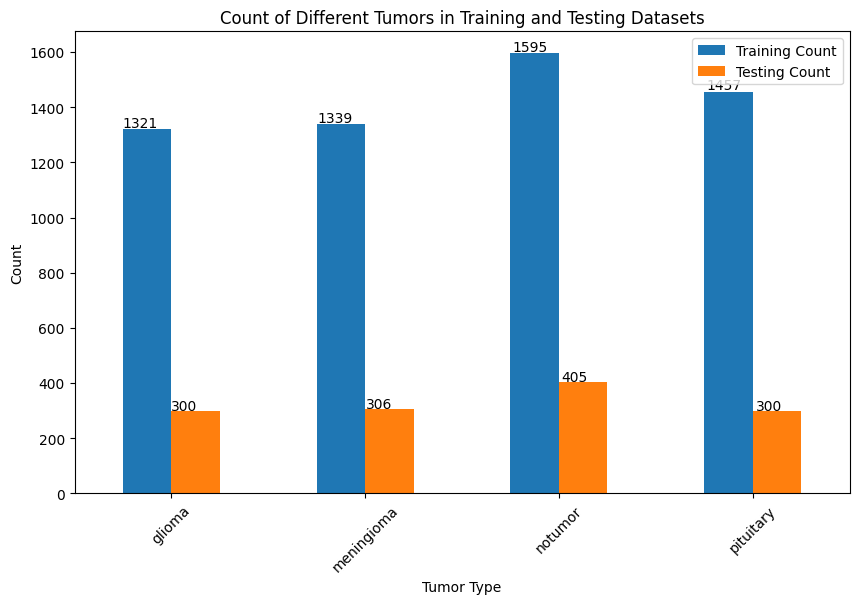

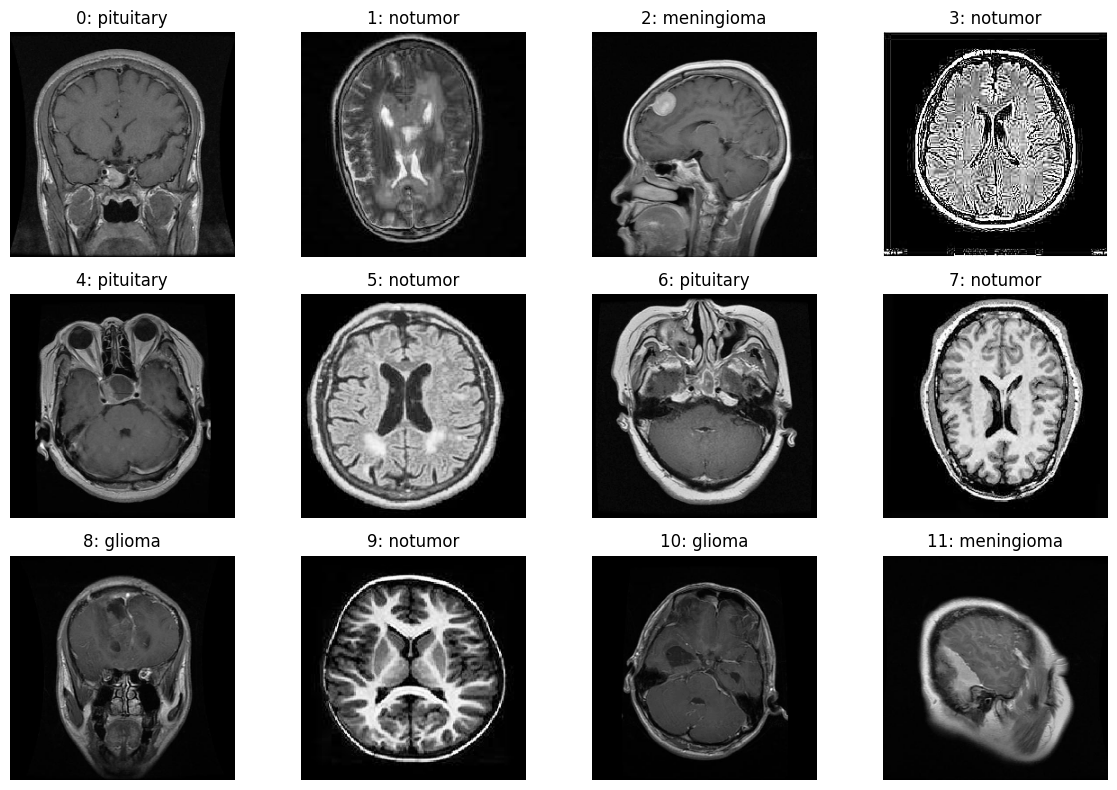

In [57]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

# Importing libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix

# Creating a base directory and defining the path
base_directory_path = '/content/drive/MyDrive/Final project'
testing_path = base_directory_path + '/Testing'
training_path = base_directory_path + '/Training'

# Function to count images
def count_and_collect_images(directory_path):
    count_dict = {}
    image_paths = []
    labels = []
    for class_dir in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_dir)
        if os.path.isdir(class_path):
            count_dict[class_dir] = len(os.listdir(class_path))
            for img_name in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, img_name))
                labels.append(class_dir)
    return count_dict, image_paths, labels

# Count the number of images in each class for training and testing data
training_counts, training_image_paths, training_labels = count_and_collect_images(training_path)
testing_counts, testing_image_paths, testing_labels = count_and_collect_images(testing_path)

# Converting to dataframe
training_df = pd.DataFrame(list(training_counts.items()), columns=['Tumor Type', 'Training Count'])
testing_df = pd.DataFrame(list(testing_counts.items()), columns=['Tumor Type', 'Testing Count'])

# Merge the training and testing dataframe on tumor type
combined_df = pd.merge(training_df, testing_df, on='Tumor Type')
combined_df.set_index('Tumor Type', inplace=True)

# Plot the counts on a bar graph
ax = combined_df.plot(kind='bar', figsize=(10, 6))
plt.title('Count of Different Tumors in Training and Testing Datasets')
plt.xlabel('Tumor Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

# Creating a class mapping
unique_labels = list(set(training_labels))
class_mappings = {label: idx for idx, label in enumerate(unique_labels)}

# Convert label to indices
training_label_indices = [class_mappings[label] for label in training_labels]
testing_label_indices = [class_mappings[label] for label in testing_labels]

# Function to display images
def show_images(paths, label_indices, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):
    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    index_to_class = {v: k for k, v in class_mappings.items()}
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images or index >= len(paths):
            ax[i].axis('off')
            continue
        image = load_img(paths[index], target_size=(im_size, im_size), color_mode='grayscale')
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_indices[index]]
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')

    for j in range(num_images, len(ax)):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()

combined = list(zip(training_image_paths, training_label_indices))
random.shuffle(combined)
training_image_paths, training_label_indices = zip(*combined)
show_images(training_image_paths, training_label_indices, class_mappings, index_list=range(12))

# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Image dimensions
image_dim = (250, 250)

# Function to load and preprocess images
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, image_dim)
    return image, label

# Function to preprocess training images
def preprocess_train(image, label):
    image = data_augmentation(image) / 255.0
    return image, label

# Function to preprocess testing images
def preprocess_test(image, label):
    return image / 255.0, label

# Convert lists to numpy arrays
training_image_paths = np.array(training_image_paths)
training_label_indices = np.array(training_label_indices)
testing_image_paths = np.array(testing_image_paths)
testing_label_indices = np.array(testing_label_indices)

# Create TensorFlow dataset from image paths and labels
train_ds = tf.data.Dataset.from_tensor_slices((training_image_paths, training_label_indices))
train_ds = train_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((testing_image_paths, testing_label_indices))
test_ds = test_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch datasets
train_ds_preprocessed = train_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)





In [58]:
# Function to display augmented images
def plot_augmented_images(dataset, shape, class_mappings, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    index_to_class = {v: k for k, v in class_mappings.items()}
    for images, label in dataset.take(1):
        i = 0
        for i in range(shape[0]*shape[1]):
            ax = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(index_to_class[label.numpy()[i]])
            plt.axis("off")
            i += 1

    plt.tight_layout()
    plt.show()

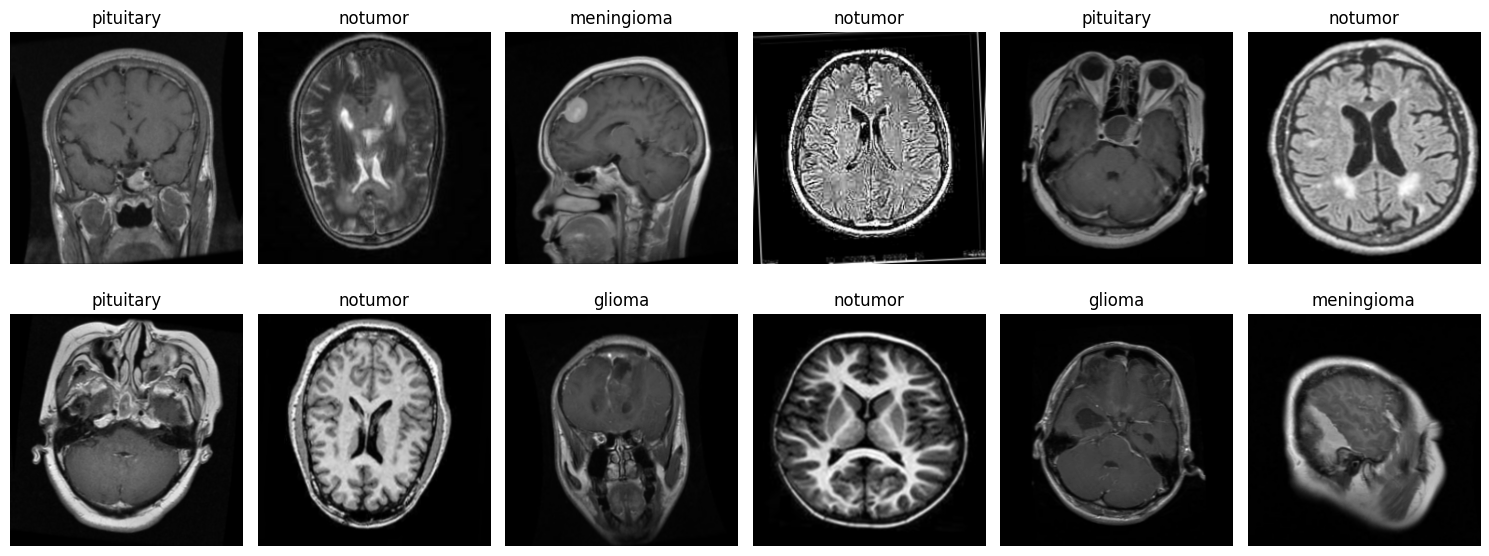

In [59]:
plot_augmented_images(train_ds_preprocessed, shape=(2, 6), class_mappings=class_mappings)


In [60]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {128}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

inv_class_mappings = {v: k for k, v in class_mappings.items()}
print(f'Inverse class mappings: {inv_class_mappings}')

Number of Classes: 4
Image shape: (250, 250, 1)
Epochs: 50
Batch size: 128
Inverse class mappings: {0: 'notumor', 1: 'glioma', 2: 'pituitary', 3: 'meningioma'}


In [65]:
# New changes or updates start here

# Image dimensions updated
image_dim = (168, 168)

# Batch size updated
batch_size = 32

# Creating a function to preprocess images and labels
def preprocess_image(image_path, label, image_dim, is_train=True):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, image_dim)
    image = image / 255.0

    if is_train:
        image = data_augmentation(image)

    return image, label

# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Function to encode labels
def encode_labels(image, label, num_classes):
    return image, tf.one_hot(label, depth=num_classes)

# Create TensorFlow dataset from image paths and labels
train_ds = tf.data.Dataset.from_tensor_slices((training_image_paths, training_label_indices))
train_ds = train_ds.map(lambda x, y: preprocess_image(x, y, image_dim, is_train=True), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: encode_labels(x, y, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
train_ds_preprocessed = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((testing_image_paths, testing_label_indices))
test_ds = test_ds.map(lambda x, y: preprocess_image(x, y, image_dim, is_train=False), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: encode_labels(x, y, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define the updated CNN model
def create_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, (5, 5), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(64, (5, 5), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model

# Model parameters
# input_shape = (image_dim[0], image_dim[1], 1)
# num_classes = len(class_mappings)

# Create and compile the model
model = create_model(input_shape, num_classes)
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds
        self.factor = factor
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Train the model
history = model.fit(
    train_ds_preprocessed,
    epochs=50,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc, lr_callback],
    verbose=True
)

# Load the best model
model = load_model('model.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_accuracy*100:.4f}%")


Epoch 1/50
179/179 [==============================] - 17s 57ms/step - loss: 0.8911 - accuracy: 0.6162 - val_loss: 0.7706 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 2/50
179/179 [==============================] - 10s 56ms/step - loss: 0.5149 - accuracy: 0.8006 - val_loss: 0.5415 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 3/50
179/179 [==============================] - 10s 56ms/step - loss: 0.3531 - accuracy: 0.8666 - val_loss: 0.3530 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 4/50
179/179 [==============================] - 10s 58ms/step - loss: 0.2533 - accuracy: 0.9065 - val_loss: 0.4712 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 5/50
179/179 [==============================] - 10s 56ms/step - loss: 0.1985 - accuracy: 0.9287 - val_loss: 0.3250 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 6/50
179/179 [==============================] - 10s 55ms/step - loss: 0.1621 - accuracy: 0.9387 - val_loss: 0.3001 - val_accuracy: 0.8932 - lr: 0.0010
Epoch 7/50
179/179 [==============================] - 10s 

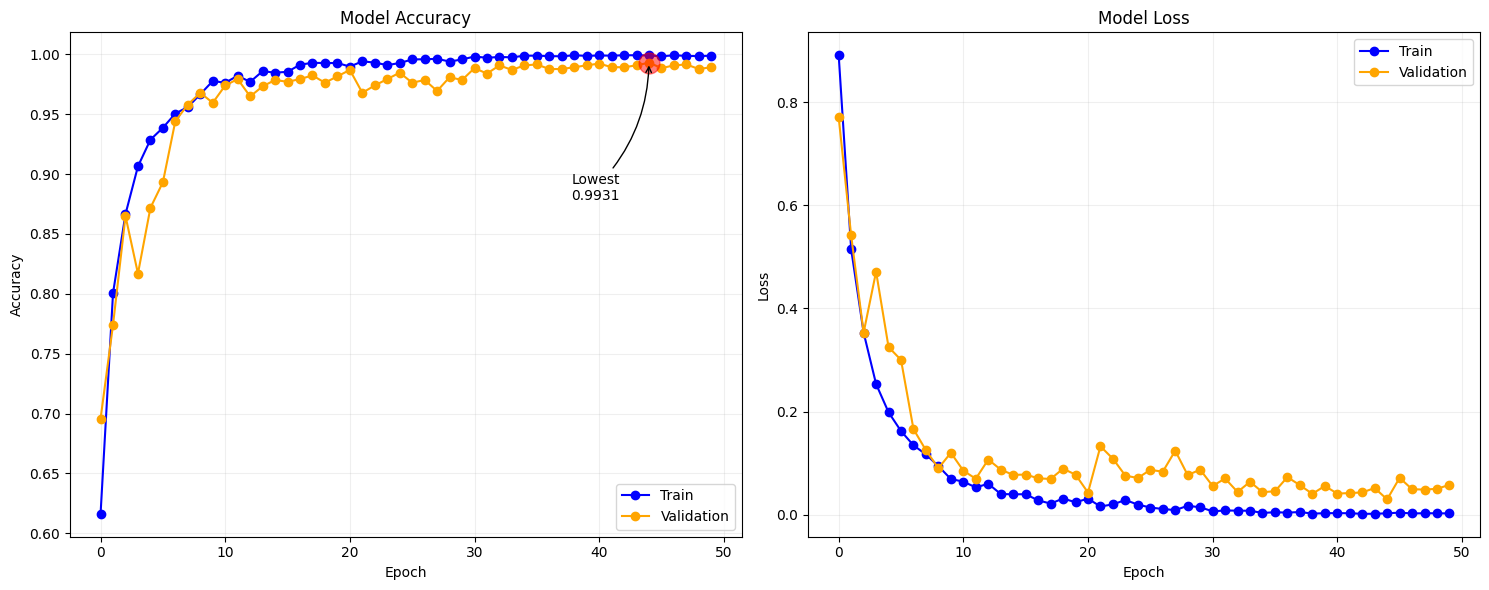

In [66]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
ax[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='lower right')
ax[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
ax[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
ax[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')
ax[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
ax[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
ax[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [67]:
# Using test data for true and preductions
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels
# Unbatch to get sample-wise prediction
for images, labels in test_ds_preprocessed.unbatch():
    # Store true labels (Convert one-hot to index)
    true_label = np.argmax(labels.numpy())
    true_labels.append(true_label)

    # Get model prediction (Predict expects batch dimension)
    pred = model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

In [68]:
def plot_confusion_matrix(true_labels, predicted_labels, class_mappings, metrics=False, cmap='Blues'):
    # Compute  confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_mappings
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_mappings)):
            class_name = list(class_mappings.keys())[i]
            print(f"\033[94mClass: {class_name}\033[0m")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"\033[92mOverall Accuracy: {accuracy:.4f}\033[0m")

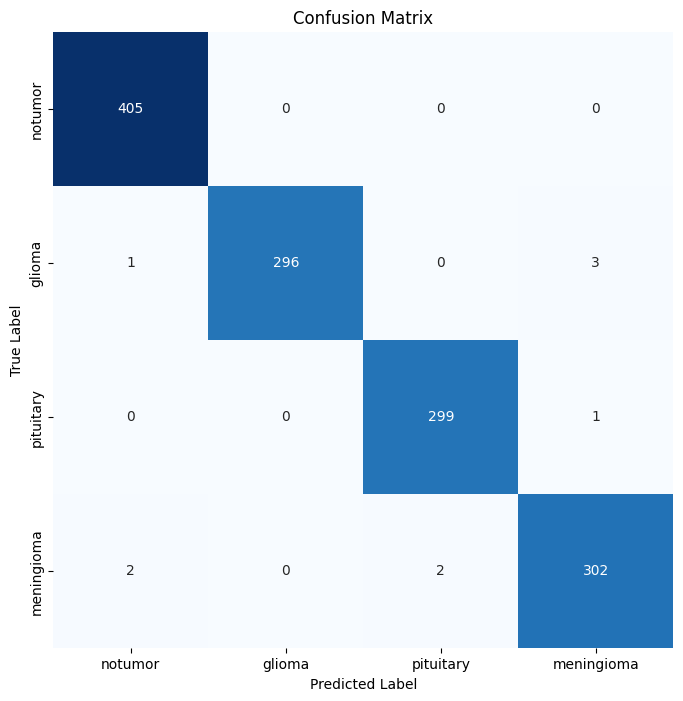

Class-wise metrics:
Class: notumor
Precision: 0.9926
Recall: 1.0000
F1-Score: 0.9963

Class: glioma
Precision: 1.0000
Recall: 0.9867
F1-Score: 0.9933

Class: pituitary
Precision: 0.9934
Recall: 0.9967
F1-Score: 0.9950

Class: meningioma
Precision: 0.9869
Recall: 0.9869
F1-Score: 0.9869

Overall Accuracy: 0.9931


In [69]:
# Confusion matrix and netrics from predictions
plot_confusion_matrix(true_labels,
                      predicted_labels,
                      class_mappings,
                      metrics=True)

In [70]:
def plot_sample_predictions(model, dataset, index_to_class, num_samples=9, figsize=(13, 12)):
    print('inside')
    plt.figure(figsize=figsize)
    num_rows = num_cols = int(np.sqrt(num_samples))
    print('num_rows', num_rows)

    iterator = iter(dataset.unbatch())

    for i in range(1, num_samples + 1):
        print('inside the loop')
        image, true_label = next(iterator)
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        print(predictions)
        predicted_label = np.argmax(predictions, axis=1)[0]

        true_class_index = np.argmax(true_label.numpy())
        true_class = index_to_class[true_class_index]
        predicted_class = index_to_class[predicted_label]

        # Determine title color based on prediction accuracy
        title_color = 'green' if true_class_index == predicted_label else 'red'

        plt.subplot(num_rows, num_cols, i)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

inside
num_rows 3
inside the loop
[[3.9940138e-14 3.5101647e-11 1.0000000e+00 1.7199195e-09]]
inside the loop
[[4.5649507e-08 1.7870315e-06 9.9999821e-01 6.9197581e-09]]
inside the loop
[[5.3044742e-11 2.7112054e-10 1.0000000e+00 1.9944090e-11]]
inside the loop
[[5.6514635e-15 1.8498924e-15 1.0000000e+00 3.3024989e-11]]
inside the loop
[[5.6487797e-14 7.4138673e-12 2.2756806e-04 9.9977249e-01]]
inside the loop
[[3.5110553e-15 2.3847776e-16 9.9999619e-01 3.7643374e-06]]
inside the loop
[[8.1842102e-16 3.7604527e-11 1.0000000e+00 2.9827535e-13]]
inside the loop
[[2.6466440e-13 4.8021613e-13 1.0000000e+00 2.1233642e-12]]
inside the loop
[[1.2960970e-15 3.5025152e-18 1.0000000e+00 3.6581623e-11]]


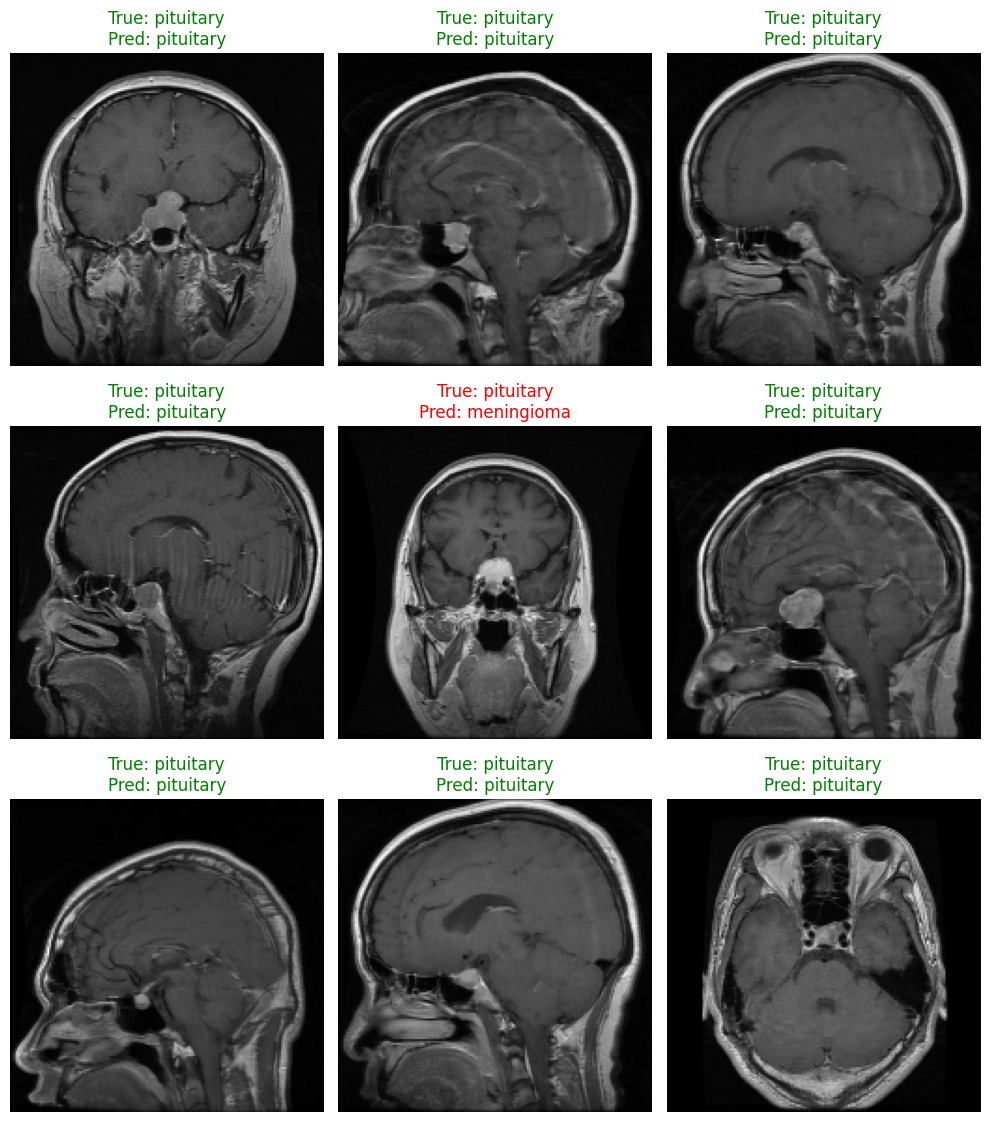

In [71]:
# Plottinng samples with predictions
plot_sample_predictions(model=model,
                        dataset=test_ds_preprocessed,
                        index_to_class=inv_class_mappings,
                        num_samples=9,
                        figsize=(10, 11.5))